In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [17]:
#Loading data from csv file
df = pd.read_csv("2176510_APPL_DATA.csv")

In [18]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [19]:
#Here i am taking consideration data one day before for the columns 'Low','High','Volume','Close' and 'Adj Close'
new_df = df.copy()
new_df['y_High']= df['High'].shift(1)
new_df['y_Low']= df['Low'].shift(1)
new_df['y_Volume']= df['Volume'].shift(1)
new_df['y_Close']= df['Close'].shift(1)
new_df['y_adj_close']= df['Adj Close'].shift(1)
new_df = new_df.drop(0).reset_index(drop = True)
new_df.dtypes

Date            object
Open           float64
High           float64
Low            float64
Close          float64
Adj Close      float64
Volume           int64
y_High         float64
y_Low          float64
y_Volume       float64
y_Close        float64
y_adj_close    float64
dtype: object

In [20]:
#Splitting the data into feature and target variable
x=new_df[['Open','y_High','y_Low','y_Volume','y_Close','y_adj_close']] 
#x=new_df[['Open']] 
y = new_df['Close']

#Normalize the data
scaler = StandardScaler()

#Splitting the data into train and test
xtrain = x[0:300]
xtest = x[300:360].reset_index(drop = True)
ytrain = y[0:300]
ytest = y[300:360].reset_index(drop = True)

### Fucntion for training testing and evaluating for all models

In [21]:
#defining the function
def modelTrainerTesterEvaluater(model,name,xtrain,xtest):
    #Training Data
    model.fit(xtrain,ytrain)
    #Predicting data
    y_pred = model.predict(xtest)
    #Calculating mean square error
    print(f"Mean square error for {name} is {mean_squared_error(ytest,y_pred)}")
    #Calculating r2 score
    print(f"r2 score for {name} is {r2_score(ytest,y_pred)}")
    
    #Plotting Real vs obtained close predictions
    plt.plot(ytest,label ='Original close rate')
    plt.plot(y_pred,label ='Predicted close rate')
    plt.xlabel('Number of days')
    plt.ylabel('Close rates')
    plt.title(f'Close rates data over days with {name}')
    plt.legend()


### Linear Regression

Mean square error for Linear Regression is 2.8132705316905082
r2 score for Linear Regression is 0.908939507951513


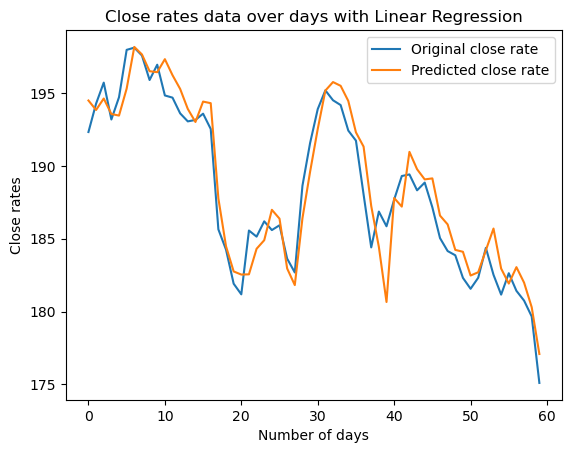

In [22]:
#Creating linear Regression object
linear_regression_model = LinearRegression()
#Passing object and other data to modelTrainerTesterEvaluater()
modelTrainerTesterEvaluater(linear_regression_model,"Linear Regression",xtrain,xtest)

### Polynomeal Regression

Mean square error for Ploynomeal Regression is 2.336851788921903
r2 score for Ploynomeal Regression is 0.9243603232086798


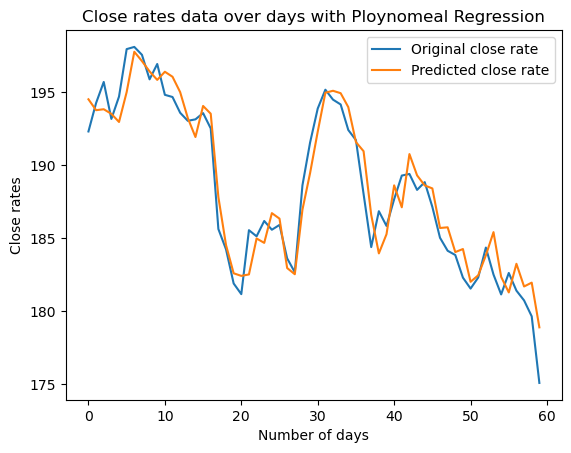

In [23]:
# Degree of the polynomial
degree = 2

# Polynomial modeling of data
poly_features = PolynomialFeatures(degree=degree)
xtrain_poly = poly_features.fit_transform(xtrain)
xtest_poly = poly_features.transform(xtest)

#Creating polynomial Regression object
polynomial_regression_model = LinearRegression()
#Passing object and other data to modelTrainerTesterEvaluater()
modelTrainerTesterEvaluater(polynomial_regression_model,"Ploynomeal Regression",xtrain_poly,xtest_poly)

### Decision Tree Regression

Mean square error for Decision tree is 4.913911148841269
r2 score for Decision tree is 0.8409455606719951


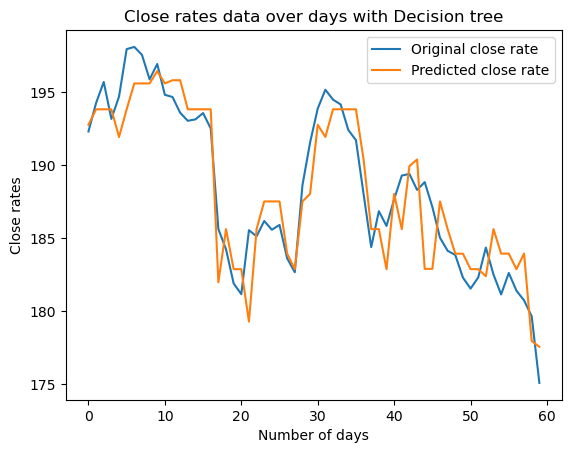

In [24]:
#Creating decision tree object with limiting max depth 7
tree = DecisionTreeRegressor(max_depth=7)
#Passing object and other data to modelTrainerTesterEvaluater()
modelTrainerTesterEvaluater(tree,"Decision tree",xtrain,xtest)

### Random Forest Regression

Mean square error for Random forest regressor is 3.542832787952909
r2 score for Random forest regressor is 0.8853248938264584


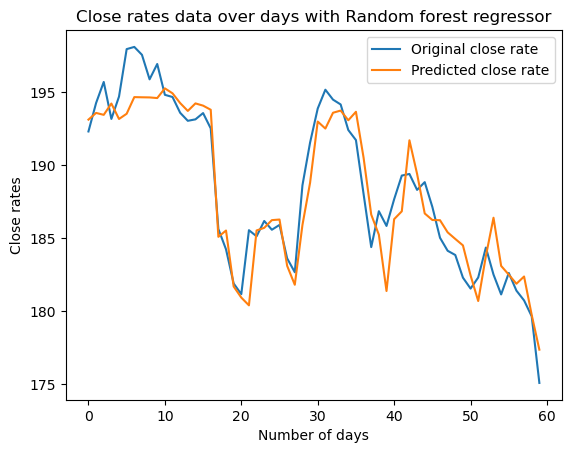

In [25]:
#Creating random forest object
rfr = RandomForestRegressor(random_state=42)
#Passing object and other data to modelTrainerTesterEvaluater()
modelTrainerTesterEvaluater(rfr,"Random forest regressor",xtrain,xtest)

### Smulation Function
Function that simulates performance of models when used on real trading scenario

In [26]:
def tradingSimulation(model,name):
    profit = 0
    total = 0
    amount = 100
    right_predictions =0
    wrong_predictions =0
    total_profit = 0
    total_loss = 0
    x1=[]
    y1=[]
    starting_day = 300
    end_day = 358
    day = 1
    df_copy = new_df[starting_day:end_day]
    if(name == "polynomeal regression" ):
        y_pred_below =model.predict(poly_features.transform(x[starting_day:end_day]))
    else:
        y_pred_below =model.predict(x[starting_day:end_day])

    for i in range(starting_day,end_day):
        open_value = new_df['Open'][i]
        lowest_value = new_df['Low'][i]
        highest_value = new_df['High'][i]
        predicted_close_value = y_pred_below[i-starting_day]
        actual_close_value = new_df['Close'][i]
        
        if(predicted_close_value<open_value):
            if(lowest_value<predicted_close_value):
                local_profit = open_value - predicted_close_value
                profit = profit + local_profit
                amount = amount*(1+(local_profit/open_value))
            elif(lowest_value>predicted_close_value):
                local_profit = open_value - actual_close_value
                profit =profit + local_profit
                amount = amount*(1+(local_profit/open_value))
        elif(predicted_close_value>open_value):
            if(highest_value>predicted_close_value):
                local_profit = predicted_close_value - open_value
                profit = profit +local_profit
                amount = amount*(1+(local_profit/open_value))
            elif(highest_value < predicted_close_value):
                local_profit = actual_close_value - open_value
                profit = profit+local_profit
                amount = amount*(1+(local_profit/open_value))
        if(local_profit>0):
            right_predictions = right_predictions+1
            total_profit = total_profit + local_profit 
        else:
            wrong_predictions=wrong_predictions+1
            total_loss = total_loss +local_profit
        x1.append(day)
        y1.append(amount)
    
        # Uncomment this to see result of every day trading from day one to fifty nine 
        #print(f"Amount on day {day} is {amount}")
        day = day+1
    
    print(f"Amount on last day is:",amount)   
    print(f"Right predictions are {right_predictions} and wrong predictions are {wrong_predictions}")

    #Plotting between days and initial and investment
    plt.plot(x1,y1)
    plt.xlabel("Day")
    plt.ylabel("Amount")
    plt.title("Initial investment of 100 pounds over time")
    plt.show()


Amount on last day is: 104.18148597833448
Right predictions are 48 and wrong predictions are 10


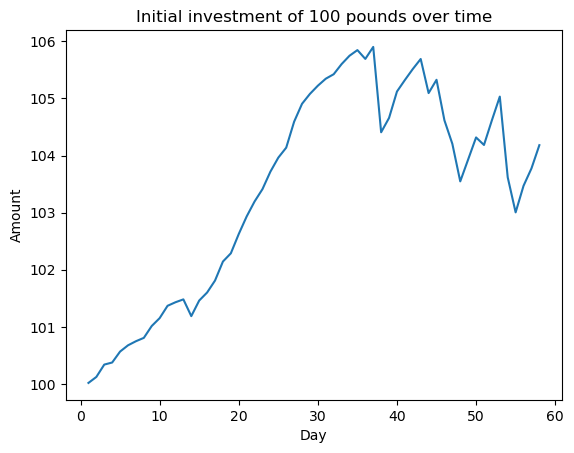

In [27]:
#Simulation for linear Regression
tradingSimulation(linear_regression_model,"Linear regression")

Amount on last day is: 109.64922846098996
Right predictions are 54 and wrong predictions are 4


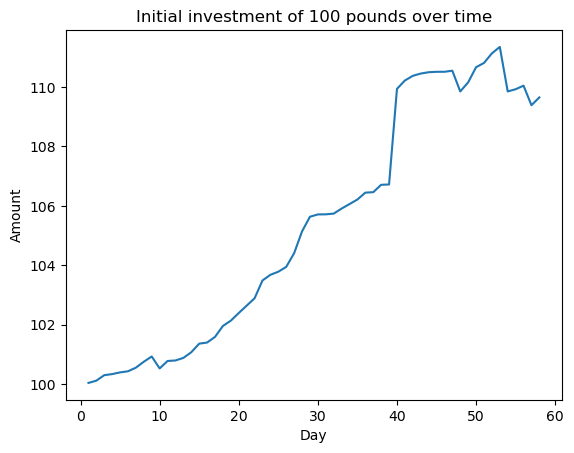

In [28]:
#Simulation for Polynomial Regression
tradingSimulation(polynomial_regression_model,"polynomeal regression")

Amount on last day is: 105.29628389612799
Right predictions are 36 and wrong predictions are 22


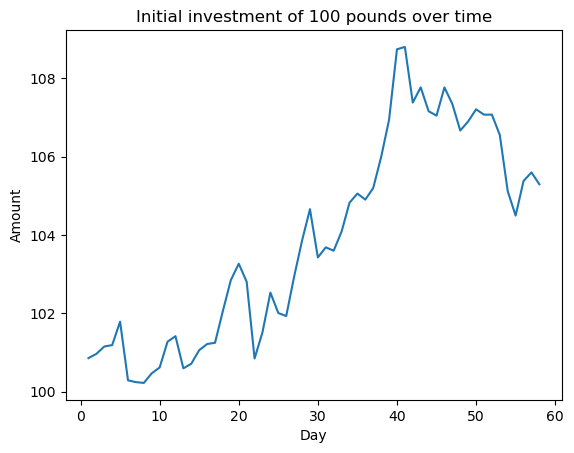

In [29]:
#Simulation for Decision tree
tradingSimulation(tree,"Decision tree")

Amount on last day is: 109.4302723117055
Right predictions are 43 and wrong predictions are 15


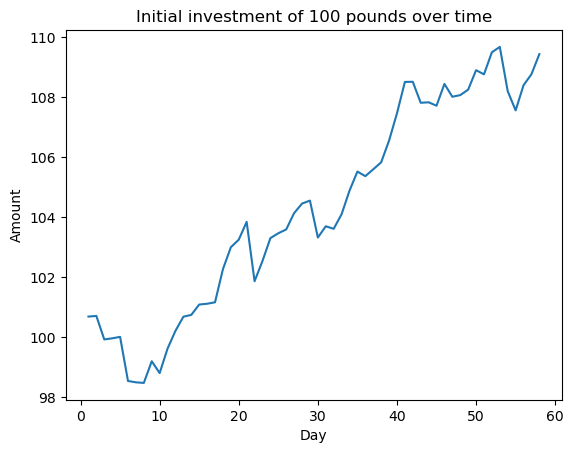

In [30]:
#Simulation for Random forest
tradingSimulation(rfr,"Random forest regressor")